In [1]:
################
#   ZELLE 01   #
################

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, accuracy_score

from scipy import stats

import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
################
#   ZELLE 02   #
################

excel_path = Path("Auswertung_Studie_Nutzungsform_aktualisiert.xlsx")  # ggf. Pfad anpassen
assert excel_path.exists(), f"Datei nicht gefunden: {excel_path.resolve()}"

df_raw = pd.read_excel(excel_path, sheet_name="Final", header=[0, 1])

def flatten_cols(cols):
    out = []
    for a, b in cols:
        a = "" if "Unnamed" in str(a) else str(a).strip()
        b = "" if "Unnamed" in str(b) else str(b).strip()
        name = "_".join([x for x in (a, b) if x])
        out.append(name)
    return out

df = df_raw.copy()
df.columns = flatten_cols(df.columns)

df.head(20)


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,Nutzung Methode_Einstellung durch Laden / Mechaniker,Nutzung Methode_Augenmaß / Gefühl,Nutzung Methode_Hüfte,Gefühl Sitzposition_Deutlich schlechter,Gefühl Sitzposition_Etwas schlechter,Gefühl Sitzposition_Kein Unterschied,Gefühl Sitzposition_Etwas besser,Gefühl Sitzposition_Deutlich besser,Längerer Zeitraum,Veränderungsimpuls
0,25,00:00:35.910000,67.7,157.3,27,x,NaN,164,75.5,70.0,...,NaN,x,NaN,NaN,x,NaN,NaN,NaN,7,1
1,24,00:00:57.040000,68.2,143.1,26,NaN,x,200,92.0,80.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,1
2,23,00:01:10.400000,75.4,150.6,23,x,NaN,166,79.6,63.5,...,NaN,x,x,NaN,x,NaN,NaN,NaN,2,9
3,22,00:01:15.850000,72.4,161.0,23,x,NaN,172,82.9,71.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,9,1
4,21,00:02:19.390000,76.2,160.7,26,x,NaN,178,87.0,76.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0
5,20,00:01:39.560000,86.4,148.6,26,NaN,x,193,92.0,77.0,...,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,10,0
6,19,00:01:14.580000,70.8,156.0,21,NaN,x,186,88.0,75.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,2
7,18,00:02:56.150000,76.6,143.2,26,NaN,x,194,91.0,75.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,4
8,17,00:02:17.640000,72.6,144.5,27,NaN,x,180,82.0,70.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0
9,16,00:01:46.760000,81.3,147.4,23,x,NaN,193,88.0,80.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0


In [3]:
# ---------- Helper: Window-Deviation erzeugen ----------
def _fmt_w(v):
    # macht aus 150.0 -> "150", 150.5 -> "150p5"
    v = float(v)
    if abs(v - round(v)) < 1e-9:
        return str(int(round(v)))
    return str(v).replace(".", "p")

def add_window_cols(df, knee_col="Kniewinkel 2", low=150, high=155):
    low, high = float(low), float(high)
    w = f"w{_fmt_w(low)}_{_fmt_w(high)}"

    x = pd.to_numeric(df[knee_col], errors="coerce")
    in_win = ((x >= low) & (x <= high)).astype(int)
    win_dev = np.where(x < low, x - low, np.where(x > high, x - high, 0.0))
    abs_win_dev = np.abs(win_dev)

    df[f"In_{w}"] = in_win
    df[f"WinDev_{w}"] = win_dev
    df[f"AbsWinDev_{w}"] = abs_win_dev
    return f"AbsWinDev_{w}"

def add_target_cols(df, knee_col="Kniewinkel 2", target=152.5):
    x = pd.to_numeric(df[knee_col], errors="coerce")
    df["Dev_Target"] = x - float(target)
    df["AbsDev_Target"] = df["Dev_Target"].abs()
    return "AbsDev_Target"

# ---------- p-Wert: einseitig aus zweiseitig ----------
def p_one_sided(p_two, stat, direction="negative"):
    # direction="negative": H1 stat < 0 ; direction="positive": H1 stat > 0
    if np.isnan(p_two) or np.isnan(stat):
        return np.nan
    if direction == "negative":
        return p_two/2 if stat < 0 else 1 - p_two/2
    else:
        return p_two/2 if stat > 0 else 1 - p_two/2

# =========================================================
# >>> HIER stellst du um, gegen was getestet wird <<<
# =========================================================
KNEE_COL = "Kniewinkel 2"

MODE = "window"      # "window" oder "target"
WINDOW = (150, 155)  # nur für MODE="window"
TARGET = 152.5       # nur für MODE="target"

if MODE == "window":
    YCOL = add_window_cols(df, knee_col=KNEE_COL, low=WINDOW[0], high=WINDOW[1])
elif MODE == "target":
    YCOL = add_target_cols(df, knee_col=KNEE_COL, target=TARGET)
else:
    raise ValueError("MODE muss 'window' oder 'target' sein")

print("Outcome-Spalte:", YCOL)
display(df[[KNEE_COL, YCOL]].head(3))

Outcome-Spalte: AbsWinDev_w150_155


,Kniewinkel 2,AbsWinDev_w150_155
0,157.3,2.3
1,143.1,6.9
2,150.6,0.0


In [4]:
def make_outcome(
    df: pd.DataFrame,
    knee_col: str = "Kniewinkel 2",
    mode: str = "window",
    target: float = 152.5,
    window: tuple[float, float] = (150.0, 155.0),
    signed: bool = False
):
    """
    Erzeugt eine Outcome-Serie "Abweichung" aus dem Kniewinkel.

    mode:
      - "target": Abweichung von target (|x-target| oder signed x-target)
      - "window": Abweichung vom Intervall [low, high] (0 innerhalb, sonst Distanz zur nächsten Grenze)
      - "zscore": z-standardisierte (signed) Abweichung von target (für Skalenvergleich)

    signed:
      - True: Vorzeichen bleibt (x - reference), False: Betrag/Distanz
    """
    x = pd.to_numeric(df[knee_col], errors="coerce")

    if mode == "target":
        dev = x - target
        return dev if signed else dev.abs()

    if mode == "window":
        low, high = window
        if signed:
            # signed: unterhalb negativ, oberhalb positiv, innen 0
            return np.where(x < low, x - low, np.where(x > high, x - high, 0.0))
        else:
            return np.where(x < low, low - x, np.where(x > high, x - high, 0.0))

    if mode == "zscore":
        dev = x - target
        z = (dev - dev.mean()) / dev.std(ddof=1)
        return z

    raise ValueError("mode muss einer von {'target','window','zscore'} sein.")


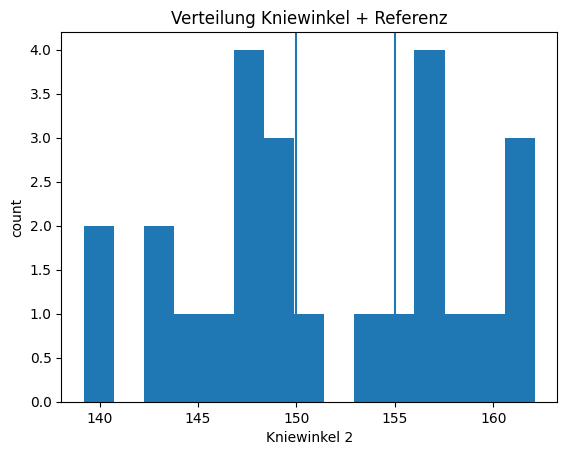

In [5]:
# ==== Outcome-Konfiguration (nur hier umstellen) ====
KNEE_COL = "Kniewinkel 2"

OUTCOME_MODE = "window"     # "window" oder "target"
TARGET = 152.5              # nur relevant für mode="target"
WINDOW = (150.0, 155.0)     # nur relevant für mode="window"
SIGNED = False              # i.d.R. False (Abweichungsbetrag)

# Outcome berechnen
df["Abweichung"] = make_outcome(
    df, knee_col=KNEE_COL,
    mode=OUTCOME_MODE,
    target=TARGET,
    window=WINDOW,
    signed=SIGNED
)


x = pd.to_numeric(df[KNEE_COL], errors="coerce").dropna()

plt.figure()
plt.hist(x, bins=15)
if OUTCOME_MODE == "window":
    plt.axvline(WINDOW[0]); plt.axvline(WINDOW[1])
else:
    plt.axvline(TARGET)
plt.title("Verteilung Kniewinkel + Referenz")
plt.xlabel(KNEE_COL)
plt.ylabel("count")
plt.show()


In [6]:


# nur echte Datensätze behalten
df = df[df["Proband Nr."].notna()].copy()

# 1) 'x' -> 1 (nur wo es vorkommt)
df = df.replace({"x": 1})

# 2) nur object-Spalten versuchen zu numerifizieren (ohne errors="ignore")
obj_cols = [c for c in df.columns if c != "Proband Nr." and df[c].dtype == "object"]
for c in obj_cols:
    try:
        df[c] = pd.to_numeric(df[c])
    except (ValueError, TypeError):
        # bleibt Text, falls wirklich Text vorhanden ist
        pass

# 3) Ben. Zeit (falls vorhanden) robust in Sekunden umrechnen
if "Ben. Zeit" in df.columns:
    df["Ben. Zeit"] = pd.to_timedelta(df["Ben. Zeit"].astype(str), errors="coerce").dt.total_seconds()

# 4) fehlende Werte auffüllen (nach Konvertierung!)
df = df.fillna(0)

# optional: falls pandas noch object dtypes hat, sauber inferieren
df = df.infer_objects(copy=False)

df.shape
df.head(3)


C:\Users\Marlon\AppData\Local\Temp\ipykernel_23756\557317780.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"x": 1})


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,Gefühl Sitzposition_Etwas schlechter,Gefühl Sitzposition_Kein Unterschied,Gefühl Sitzposition_Etwas besser,Gefühl Sitzposition_Deutlich besser,Längerer Zeitraum,Veränderungsimpuls,In_w150_155,WinDev_w150_155,AbsWinDev_w150_155,Abweichung
0,25,35.91,67.7,157.3,27,1.0,0.0,164,75.5,70.0,...,1.0,0.0,0.0,0.0,7,1,0,2.3,2.3,2.3
1,24,57.04,68.2,143.1,26,0.0,1.0,200,92.0,80.0,...,0.0,1.0,0.0,0.0,8,1,0,-6.9,6.9,6.9
2,23,70.40,75.4,150.6,23,1.0,0.0,166,79.6,63.5,...,1.0,0.0,0.0,0.0,2,9,1,0.0,0.0,0.0


In [7]:

cols = [
    'Fahrradtyp_E-Bike',
    'Fahrradtyp_Trecking',
    'Fahrradtyp_Crosscountry',
    'Fahrradtyp_Sonstige'
]

df['Fahrradtyp_Sonstige'] = df[cols].max(axis=1).astype(int)


#print(df[cols].head(25))

df = df.drop(columns=[
    'Fahrradtyp_E-Bike',
    'Fahrradtyp_Trecking',
    'Fahrradtyp_Crosscountry'
])

#print(df['Fahrradtyp_Sonstige'].head(25))

In [8]:
# 1) Spaltennamen + Datentypen + Beispielwerte
import pandas as pd
import numpy as np

print("df shape:", df.shape)
display(df.head(3))

# dtypes
display(pd.DataFrame({"col": df.columns, "dtype": df.dtypes.astype(str)}))

# NA-Anteile
na = df.isna().mean().sort_values(ascending=False)
display(na.head(30))

# Für alle object-Spalten: häufigste Werte (zeigt mir Checkboxen, Kategorien etc.)
obj_cols = df.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
    vc = df[c].astype(str).str.strip().replace({"": np.nan}).value_counts(dropna=False).head(8)
    print("\n---", c, "---")
    print(vc)


df shape: (25, 56)


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,Gefühl Sitzposition_Etwas schlechter,Gefühl Sitzposition_Kein Unterschied,Gefühl Sitzposition_Etwas besser,Gefühl Sitzposition_Deutlich besser,Längerer Zeitraum,Veränderungsimpuls,In_w150_155,WinDev_w150_155,AbsWinDev_w150_155,Abweichung
0,25,35.91,67.7,157.3,27,1.0,0.0,164,75.5,70.0,...,1.0,0.0,0.0,0.0,7,1,0,2.3,2.3,2.3
1,24,57.04,68.2,143.1,26,0.0,1.0,200,92.0,80.0,...,0.0,1.0,0.0,0.0,8,1,0,-6.9,6.9,6.9
2,23,70.40,75.4,150.6,23,1.0,0.0,166,79.6,63.5,...,1.0,0.0,0.0,0.0,2,9,1,0.0,0.0,0.0


,col,dtype
Proband Nr.,Proband Nr.,int64
Ben. Zeit,Ben. Zeit,float64
Kniewinkel 1,Kniewinkel 1,float64
Kniewinkel 2,Kniewinkel 2,float64
Alter,Alter,int64
Geschlecht_weiblich,Geschlecht_weiblich,float64
Geschlecht_männlich,Geschlecht_männlich,float64
Größe,Größe,int64
Beininnenlänge,Beininnenlänge,float64
Sitzhöhe,Sitzhöhe,float64


Proband Nr.                                             0.0
Ben. Zeit                                               0.0
Satteleinstellung, wer_Professioneller Fitter           0.0
Satteleinstellung, wer_Sonstige                         0.0
Zuverlässigkeit                                         0.0
Dauer Satteleinst.                                      0.0
Methode bekannt_Formeln / Berechnung nach Beinlänge     0.0
Methode bekannt_Fersenmethode                           0.0
Methode bekannt_Kniewinkel                              0.0
Methode bekannt_Hüfte                                   0.0
Methode bekannt_keine                                   0.0
Nutzung Methode_Formeln / Berechnung nach Beinlänge     0.0
Nutzung Methode_Fersenmethode                           0.0
Nutzung Methode_Kniewinkel                              0.0
Nutzung Methode_Einstellung durch Laden / Mechaniker    0.0
Nutzung Methode_Augenmaß / Gefühl                       0.0
Nutzung Methode_Hüfte                   

Welch t-test (zweiseitig): t=-0.3830, p=0.708145
Means: {'weiblich': 3.299999999999997, 'männlich': 3.7578947368421054} | n: {'weiblich': 6, 'männlich': 19}


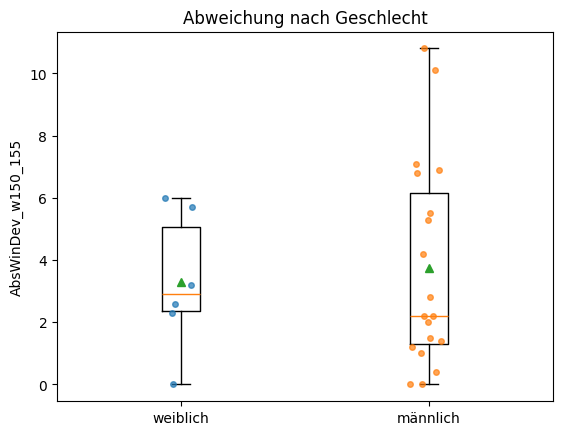

In [9]:
################
# HYPOTHESE 01 #
################

sub = df[[YCOL, "Geschlecht_weiblich", "Geschlecht_männlich"]].dropna()
sub = sub[(sub["Geschlecht_weiblich"] + sub["Geschlecht_männlich"]) == 1]

sub["Geschlecht"] = np.where(sub["Geschlecht_weiblich"] == 1, "weiblich", "männlich")
w = sub.loc[sub["Geschlecht"]=="weiblich", YCOL]
m = sub.loc[sub["Geschlecht"]=="männlich", YCOL]

t, p = stats.ttest_ind(w, m, equal_var=False)
print(f"Welch t-test (zweiseitig): t={t:.4f}, p={p:.6f}")
print("Means:", {"weiblich": w.mean(), "männlich": m.mean()}, "| n:", {"weiblich": len(w), "männlich": len(m)})

plt.figure()
plt.boxplot([w.values, m.values], labels=["weiblich","männlich"], showmeans=True)
for i, vals in enumerate([w.values, m.values], start=1):
    plt.plot(np.random.normal(i, 0.04, len(vals)), vals, "o", alpha=0.7, markersize=4)
plt.ylabel(YCOL)
plt.title("Abweichung nach Geschlecht")
plt.show()


Regression (zweiseitig): slope=0.252041, r=0.1881, p=0.367987, n=25


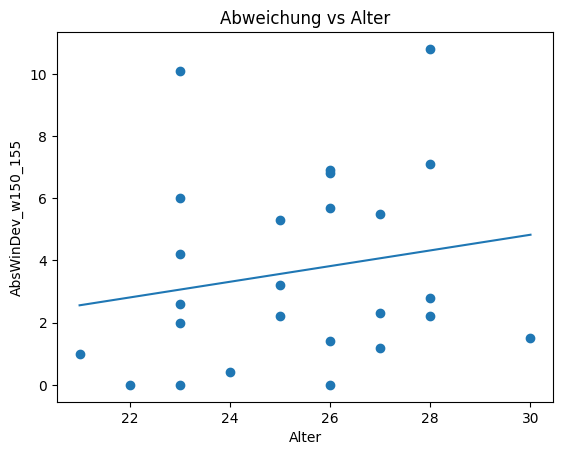

In [10]:
################
# HYPOTHESE 02 #
################

sub = df[[YCOL, "Alter"]].dropna()
res = stats.linregress(sub["Alter"], sub[YCOL])

print(f"Regression (zweiseitig): slope={res.slope:.6f}, r={res.rvalue:.4f}, p={res.pvalue:.6f}, n={len(sub)}")

fig, ax = plt.subplots()
ax.scatter(sub["Alter"], sub[YCOL])
xs = np.linspace(sub["Alter"].min(), sub["Alter"].max(), 100)
ax.plot(xs, res.slope*xs + res.intercept)
ax.set_xlabel("Alter"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs Alter")
plt.show()


Regression (zweiseitig): slope=0.080035, r=0.2484, p=0.231116, n=25


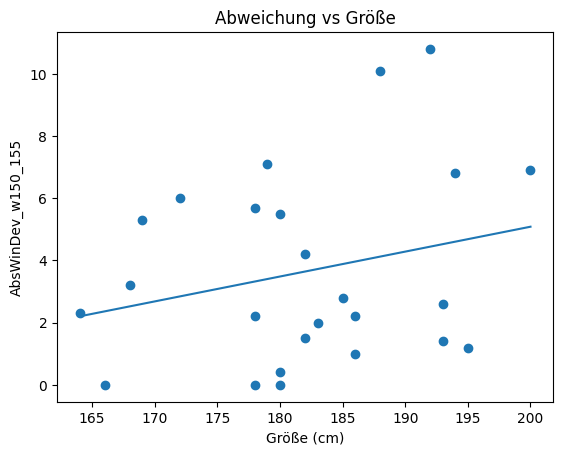

In [11]:
################
# HYPOTHESE 03 #
################

sub = df[[YCOL, "Größe"]].dropna()
res = stats.linregress(sub["Größe"], sub[YCOL])

print(f"Regression (zweiseitig): slope={res.slope:.6f}, r={res.rvalue:.4f}, p={res.pvalue:.6f}, n={len(sub)}")

fig, ax = plt.subplots()
ax.scatter(sub["Größe"], sub[YCOL])
xs = np.linspace(sub["Größe"].min(), sub["Größe"].max(), 100)
ax.plot(xs, res.slope*xs + res.intercept)
ax.set_xlabel("Größe (cm)"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs Größe")
plt.show()


Regression (zweiseitig): slope=0.163901, r=0.2633, p=0.203552, n=25


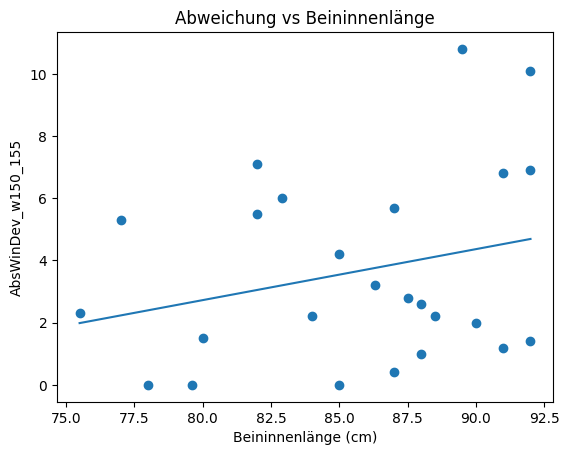

In [12]:
################
# HYPOTHESE 04 #
################

sub = df[[YCOL, "Beininnenlänge"]].dropna()
res = stats.linregress(sub["Beininnenlänge"], sub[YCOL])

print(f"Regression (zweiseitig): slope={res.slope:.6f}, r={res.rvalue:.4f}, p={res.pvalue:.6f}, n={len(sub)}")

fig, ax = plt.subplots()
ax.scatter(sub["Beininnenlänge"], sub[YCOL])
xs = np.linspace(sub["Beininnenlänge"].min(), sub["Beininnenlänge"].max(), 100)
ax.plot(xs, res.slope*xs + res.intercept)
ax.set_xlabel("Beininnenlänge (cm)"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs Beininnenlänge")
plt.show()


Regression: slope=0.004659, r=0.1179, p(zweiseitig)=0.574466, n=25
Einseitig (H1: slope < 0): p=0.712767


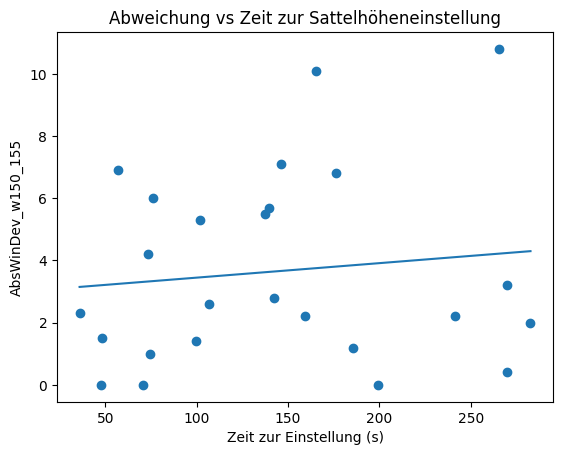

In [13]:
################
# HYPOTHESE 05 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

sub = df[[YCOL, "Ben. Zeit"]].dropna()
res = stats.linregress(sub["Ben. Zeit"], sub[YCOL])
p1 = p_one_sided(res.pvalue, res.slope, direction="negative")

print(f"Regression: slope={res.slope:.6f}, r={res.rvalue:.4f}, p(zweiseitig)={res.pvalue:.6f}, n={len(sub)}")
print(f"Einseitig (H1: slope < 0): p={p1:.6f}")

fig, ax = plt.subplots()
ax.scatter(sub["Ben. Zeit"], sub[YCOL])
xs = np.linspace(sub["Ben. Zeit"].min(), sub["Ben. Zeit"].max(), 100)
ax.plot(xs, res.slope*xs + res.intercept)
ax.set_xlabel("Zeit zur Einstellung (s)"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs Zeit zur Sattelhöheneinstellung")
plt.show()


Regression: slope=0.024150, r=0.1782, p(zweiseitig)=0.393951, n=25
Einseitig (H1: slope < 0): p=0.803024


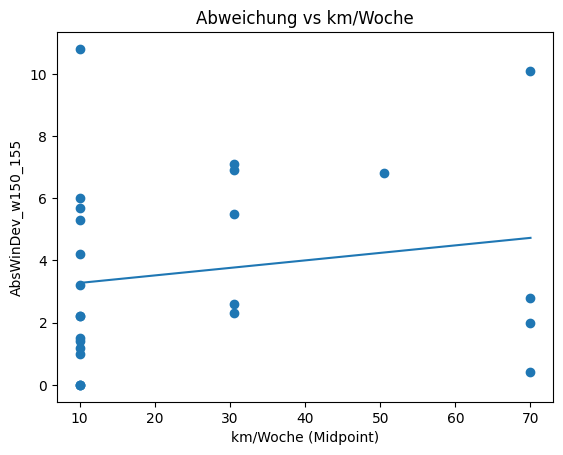

In [14]:
################
# HYPOTHESE 06 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

km_cols = ["km/Woche_<20", "km/Woche_21-40", "km/Woche_41-60", "km/Woche_>60"]
mid = {"km/Woche_<20": 10.0, "km/Woche_21-40": 30.5, "km/Woche_41-60": 50.5, "km/Woche_>60": 70.0}

sub = df[[YCOL] + km_cols].dropna()
sub = sub[sub[km_cols].sum(axis=1) == 1].copy()
sub["KmWoche_mid"] = sum(sub[c] * mid[c] for c in km_cols)

res = stats.linregress(sub["KmWoche_mid"], sub[YCOL])
p1 = p_one_sided(res.pvalue, res.slope, direction="negative")

print(f"Regression: slope={res.slope:.6f}, r={res.rvalue:.4f}, p(zweiseitig)={res.pvalue:.6f}, n={len(sub)}")
print(f"Einseitig (H1: slope < 0): p={p1:.6f}")

fig, ax = plt.subplots()
ax.scatter(sub["KmWoche_mid"], sub[YCOL])
xs = np.linspace(sub["KmWoche_mid"].min(), sub["KmWoche_mid"].max(), 100)
ax.plot(xs, res.slope*xs + res.intercept)
ax.set_xlabel("km/Woche (Midpoint)"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs km/Woche")
plt.show()



Regression: slope=0.118254, r=0.0639, p(zweiseitig)=0.761627, n=25
Einseitig (H1: slope < 0): p=0.619187


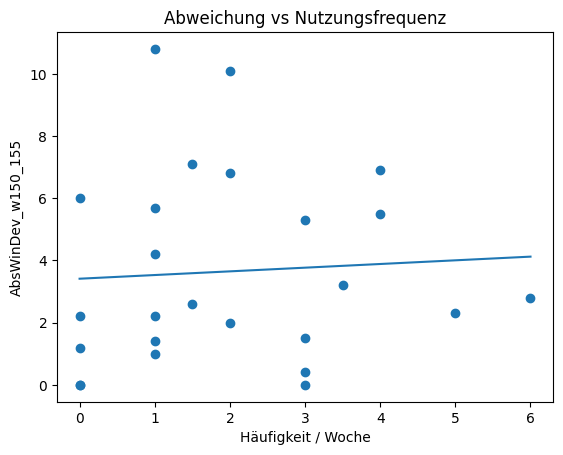

In [15]:
################
# HYPOTHESE 07 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

sub = df[[YCOL, "Häufigkeit / Woche"]].dropna()
res = stats.linregress(sub["Häufigkeit / Woche"], sub[YCOL])
p1 = p_one_sided(res.pvalue, res.slope, direction="negative")

print(f"Regression: slope={res.slope:.6f}, r={res.rvalue:.4f}, p(zweiseitig)={res.pvalue:.6f}, n={len(sub)}")
print(f"Einseitig (H1: slope < 0): p={p1:.6f}")

fig, ax = plt.subplots()
ax.scatter(sub["Häufigkeit / Woche"], sub[YCOL])
xs = np.linspace(sub["Häufigkeit / Woche"].min(), sub["Häufigkeit / Woche"].max(), 100)
ax.plot(xs, res.slope*xs + res.intercept)
ax.set_xlabel("Häufigkeit / Woche"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs Nutzungsfrequenz")
plt.show()


Regression: slope=0.169904, r=0.3926, p(zweiseitig)=0.052208, n=25
Einseitig (H1: slope < 0): p=0.973896


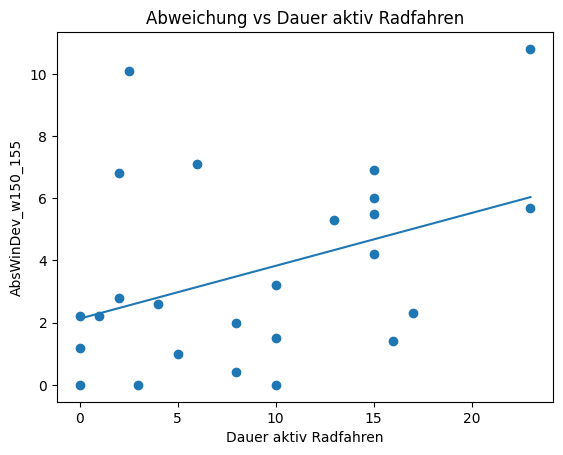

In [16]:
################
# HYPOTHESE 08 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

sub = df[[YCOL, "Dauer aktives Radfahren"]].dropna()
res = stats.linregress(sub["Dauer aktives Radfahren"], sub[YCOL])
p1 = p_one_sided(res.pvalue, res.slope, direction="negative")

print(f"Regression: slope={res.slope:.6f}, r={res.rvalue:.4f}, p(zweiseitig)={res.pvalue:.6f}, n={len(sub)}")
print(f"Einseitig (H1: slope < 0): p={p1:.6f}")

fig, ax = plt.subplots()
ax.scatter(sub["Dauer aktives Radfahren"], sub[YCOL])
xs = np.linspace(sub["Dauer aktives Radfahren"].min(), sub["Dauer aktives Radfahren"].max(), 100)
ax.plot(xs, res.slope*xs + res.intercept)
ax.set_xlabel("Dauer aktiv Radfahren"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs Dauer aktiv Radfahren")
plt.show()


Welch t-test: t=1.3865, p(zweiseitig)=0.179867
Einseitig (H1: Sport < nicht Sport): p=0.910066
Means: {'Sport': 4.5909090909090935, 'nicht': 2.9071428571428544} | n: {'Sport': 11, 'nicht': 14}


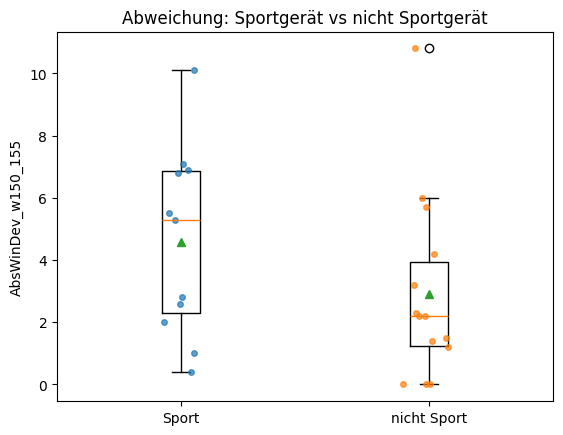

In [17]:
################
# HYPOTHESE 09 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

SPORT_COL = "Form der Fahrradnutzung_Sport / Training"

sub = df[[YCOL, SPORT_COL]].dropna()
g1 = sub.loc[sub[SPORT_COL].astype(int)==1, YCOL]
g0 = sub.loc[sub[SPORT_COL].astype(int)==0, YCOL]

t, p2 = stats.ttest_ind(g1, g0, equal_var=False)
p1 = p_one_sided(p2, t, direction="negative")

print(f"Welch t-test: t={t:.4f}, p(zweiseitig)={p2:.6f}")
print(f"Einseitig (H1: Sport < nicht Sport): p={p1:.6f}")
print("Means:", {"Sport": g1.mean(), "nicht": g0.mean()}, "| n:", {"Sport": len(g1), "nicht": len(g0)})

fig, ax = plt.subplots()
ax.boxplot([g1.values, g0.values], tick_labels=["Sport","nicht Sport"], showmeans=True)
for i, vals in enumerate([g1.values, g0.values], start=1):
    ax.plot(np.random.normal(i, 0.04, len(vals)), vals, "o", alpha=0.7, markersize=4)
ax.set_ylabel(YCOL); ax.set_title("Abweichung: Sportgerät vs nicht Sportgerät")
plt.show()


Welch t-test: t=1.6968, p(zweiseitig)=0.105445
Einseitig (H1: Fortbewegung < nicht): p=0.947277


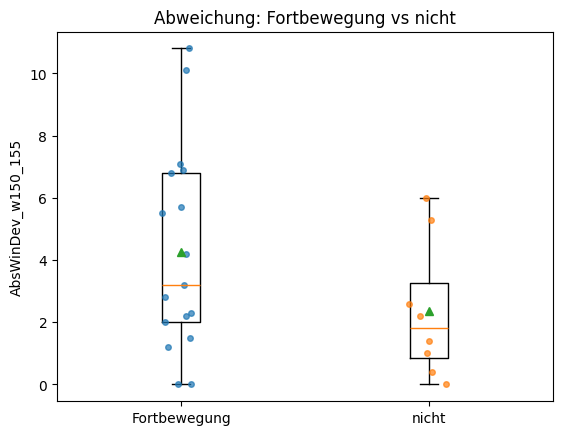

In [18]:
################
# HYPOTHESE 10 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

FORT_COL = "Form der Fahrradnutzung_Reines Fortbewegungsmittel"

sub = df[[YCOL, FORT_COL]].dropna()
g1 = sub.loc[sub[FORT_COL].astype(int)==1, YCOL]
g0 = sub.loc[sub[FORT_COL].astype(int)==0, YCOL]

t, p2 = stats.ttest_ind(g1, g0, equal_var=False)
p1 = p_one_sided(p2, t, direction="negative")

print(f"Welch t-test: t={t:.4f}, p(zweiseitig)={p2:.6f}")
print(f"Einseitig (H1: Fortbewegung < nicht): p={p1:.6f}")

fig, ax = plt.subplots()
ax.boxplot([g1.values, g0.values], tick_labels=["Fortbewegung","nicht"], showmeans=True)
for i, vals in enumerate([g1.values, g0.values], start=1):
    ax.plot(np.random.normal(i, 0.04, len(vals)), vals, "o", alpha=0.7, markersize=4)
ax.set_ylabel(YCOL); ax.set_title("Abweichung: Fortbewegung vs nicht")
plt.show()


Gruppen n: {'Citybike': 8, 'Mehrfach': 7, 'Mountainbike': 6, 'Rennrad': 2, 'Sonstige': 1}
Kruskal-Wallis: H=1.8928, p=0.755467


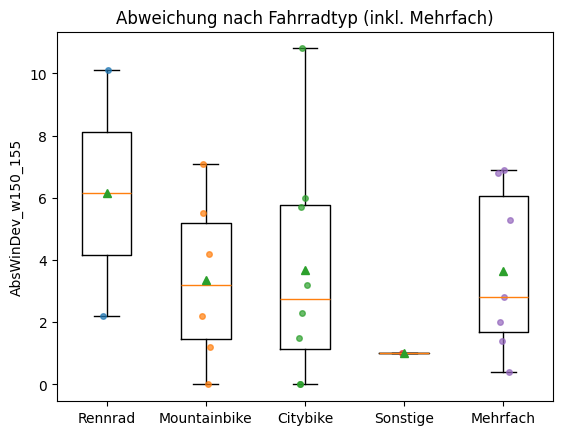

In [19]:
################
# HYPOTHESE 11 # Berücksichtigung von Mehrfachnennungen
################

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

bike_cols = {
    "Rennrad": "Fahrradtyp_Rennrad",         
    "Mountainbike": "Fahrradtyp_Moutainbike",
    "Citybike": "Fahrradtyp_City/Commuter",
    "Sonstige": "Fahrradtyp_Sonstige",
}

sub = df[[YCOL] + list(bike_cols.values())].dropna().copy()
sub["n_checked"] = sub[list(bike_cols.values())].sum(axis=1)

def assign_type(row):
    if row["n_checked"] == 0:
        return np.nan
    if row["n_checked"] > 1:
        return "Mehrfach"
    for lab, col in bike_cols.items():
        if int(row[col]) == 1:
            return lab
    return np.nan

sub["Typ"] = sub.apply(assign_type, axis=1)
sub = sub.dropna(subset=["Typ"]).copy()

# Reihenfolge wie gewünscht
order = ["Rennrad", "Gravelbike", "Mountainbike", "Citybike", "Sonstige", "Mehrfach"]
labels = [lab for lab in order if lab in sub["Typ"].unique()]

print("Gruppen n:", sub["Typ"].value_counts().to_dict())

# Test (Kruskal-Wallis)
groups = [sub.loc[sub["Typ"] == lab, YCOL].values for lab in labels]
if len(groups) >= 2:
    H, p = stats.kruskal(*groups)
    print(f"Kruskal-Wallis: H={H:.4f}, p={p:.6f}")
else:
    print("Zu wenig Gruppen für Kruskal-Wallis.")

# Plot: Boxplot + Jitter
fig, ax = plt.subplots()
ax.boxplot(groups, tick_labels=labels, showmeans=True)

for i, lab in enumerate(labels, start=1):
    vals = sub.loc[sub["Typ"] == lab, YCOL].values
    xj = np.random.normal(i, 0.04, size=len(vals))
    ax.plot(xj, vals, "o", alpha=0.7, markersize=4)

ax.set_ylabel(YCOL)
ax.set_title("Abweichung nach Fahrradtyp (inkl. Mehrfach)")
plt.show()


Einträge pro Typ (Mehrfachnennung zählt mehrfach): {'Citybike': 12, 'Mountainbike': 10, 'Rennrad': 6, 'Gravelbike': 4, 'Sonstige': 4}
Unique Probanden pro Typ: {'Citybike': 12, 'Gravelbike': 4, 'Mountainbike': 10, 'Rennrad': 6, 'Sonstige': 4}
Omnibus-Test (Likelihood Ratio): LR=0.0964, df=4, p=0.998876

Fixed Effects (Referenzkategorie ist alphabetisch; kann man umstellen):
              Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: AbsWinDev_w150_155
No. Observations:   36      Method:             ML                
No. Groups:         25      Scale:              0.0000            
Min. group size:    1       Log-Likelihood:     28.4261           
Max. group size:    4       Converged:          Yes               
Mean group size:    1.4                                           
------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------

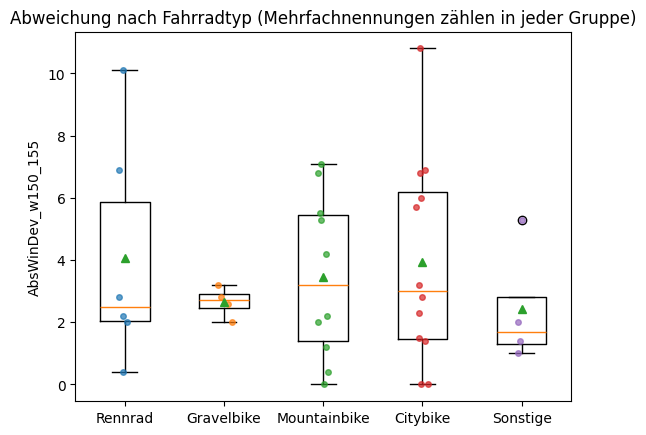

In [20]:
################
# HYPOTHESE 11 # mixed Model für mehrfachnennung erlauben
################


# Robust: finde Rennrad-Spalte, falls bei dir Tippfehler "Rennard" existiert
rennrad_col = "Fahrradtyp_Rennrad" if "Fahrradtyp_Rennrad" in df.columns else "Fahrradtyp_Rennard"

bike_cols = {
    "Rennrad": rennrad_col,
    "Gravelbike": "Fahrradtyp_Gravelbike",
    "Mountainbike": "Fahrradtyp_Moutainbike",
    "Citybike": "Fahrradtyp_City/Commuter",
    "Sonstige": "Fahrradtyp_Sonstige",
}

# ---- Long-Format: jede 1 wird zu einer Zeile (Person kann mehrfach vorkommen) ----
need = ["Proband Nr.", YCOL] + list(bike_cols.values())
sub = df[need].dropna().copy()

long = sub.melt(
    id_vars=["Proband Nr.", YCOL],
    value_vars=list(bike_cols.values()),
    var_name="bike_col",
    value_name="checked"
)
long = long[long["checked"].astype(int) == 1].copy()

inv = {v: k for k, v in bike_cols.items()}
long["Typ"] = long["bike_col"].map(inv)

# Überblick
counts_entries = long["Typ"].value_counts().to_dict()
counts_subjects = long.groupby("Typ")["Proband Nr."].nunique().to_dict()
print("Einträge pro Typ (Mehrfachnennung zählt mehrfach):", counts_entries)
print("Unique Probanden pro Typ:", counts_subjects)

# ---- Statistik: Mixed Effects (Random Intercept pro Proband) ----
# Nullmodell: nur Intercept
m0 = smf.mixedlm(f"{YCOL} ~ 1", data=long, groups=long["Proband Nr."]).fit(reml=False)
# Vollmodell: Typ als Faktor
m1 = smf.mixedlm(f"{YCOL} ~ C(Typ)", data=long, groups=long["Proband Nr."]).fit(reml=False)

LR = 2 * (m1.llf - m0.llf)
df_lr = (long["Typ"].nunique() - 1)
p_lr = stats.chi2.sf(LR, df_lr)

print(f"Omnibus-Test (Likelihood Ratio): LR={LR:.4f}, df={df_lr}, p={p_lr:.6f}")
print("\nFixed Effects (Referenzkategorie ist alphabetisch; kann man umstellen):")
print(m1.summary())

# ---- Plot: Boxplot + Jitter wie bei deinen anderen ----
order = ["Rennrad", "Gravelbike", "Mountainbike", "Citybike", "Sonstige"]
labels = [o for o in order if o in long["Typ"].unique()]
data = [long.loc[long["Typ"] == lab, YCOL].values for lab in labels]

fig, ax = plt.subplots()
ax.boxplot(data, tick_labels=labels, showmeans=True)

for i, lab in enumerate(labels, start=1):
    vals = long.loc[long["Typ"] == lab, YCOL].values
    ax.plot(np.random.normal(i, 0.04, size=len(vals)), vals, "o", alpha=0.7, markersize=4)

ax.set_ylabel(YCOL)
ax.set_title("Abweichung nach Fahrradtyp (Mehrfachnennungen zählen in jeder Gruppe)")
plt.show()


Spearman: rho=0.2131, p(zweiseitig)=0.306310, n=25
Einseitig (H1: rho < 0): p=0.846845


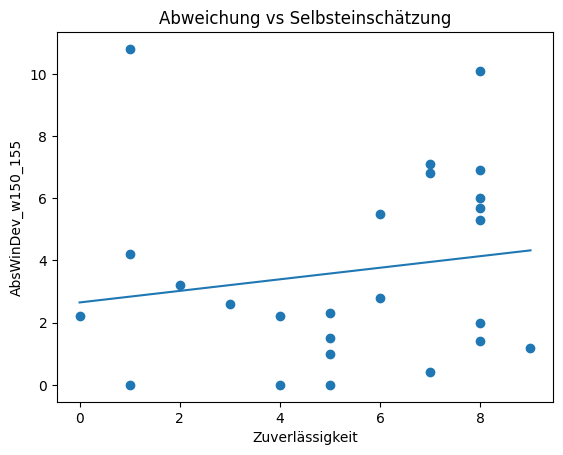

In [21]:
################
# HYPOTHESE 12 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

sub = df[[YCOL, "Zuverlässigkeit"]].dropna()
rho, p2 = stats.spearmanr(sub["Zuverlässigkeit"], sub[YCOL])
p1 = p_one_sided(p2, rho, direction="negative")

print(f"Spearman: rho={rho:.4f}, p(zweiseitig)={p2:.6f}, n={len(sub)}")
print(f"Einseitig (H1: rho < 0): p={p1:.6f}")

fig, ax = plt.subplots()
ax.scatter(sub["Zuverlässigkeit"], sub[YCOL])
m, b = np.polyfit(sub["Zuverlässigkeit"], sub[YCOL], 1)
xs = np.linspace(sub["Zuverlässigkeit"].min(), sub["Zuverlässigkeit"].max(), 100)
ax.plot(xs, m*xs + b)
ax.set_xlabel("Zuverlässigkeit"); ax.set_ylabel(YCOL); ax.set_title("Abweichung vs Selbsteinschätzung")
plt.show()


Spearman: rho=0.0624, p(zweiseitig)=0.766898, n=25
Einseitig (H1: rho > 0): p=0.383449


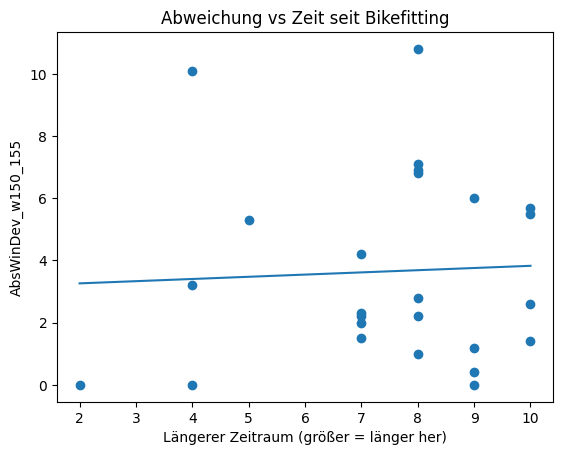

In [22]:
################
# HYPOTHESE 13 #
################

def p_one_sided(p_two, stat, direction="positive"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

sub = df[[YCOL, "Längerer Zeitraum"]].dropna()
rho, p2 = stats.spearmanr(sub["Längerer Zeitraum"], sub[YCOL])
p1 = p_one_sided(p2, rho, direction="positive")

print(f"Spearman: rho={rho:.4f}, p(zweiseitig)={p2:.6f}, n={len(sub)}")
print(f"Einseitig (H1: rho > 0): p={p1:.6f}")

fig, ax = plt.subplots()
ax.scatter(sub["Längerer Zeitraum"], sub[YCOL])
m, b = np.polyfit(sub["Längerer Zeitraum"], sub[YCOL], 1)
xs = np.linspace(sub["Längerer Zeitraum"].min(), sub["Längerer Zeitraum"].max(), 100)
ax.plot(xs, m*xs + b)
ax.set_xlabel("Längerer Zeitraum (größer = länger her)")
ax.set_ylabel(YCOL)
ax.set_title("Abweichung vs Zeit seit Bikefitting")
plt.show()


n Methode (objektiv >=1): 13 | n Gefühl-only: 12
Means: {'Methode': 3.230769230769233, 'Gefühl-only': 4.099999999999997}
Welch t-test: t=-0.7055, p(zweiseitig)=0.487598
Einseitig (H1: Methode < Gefühl-only): p=0.243799


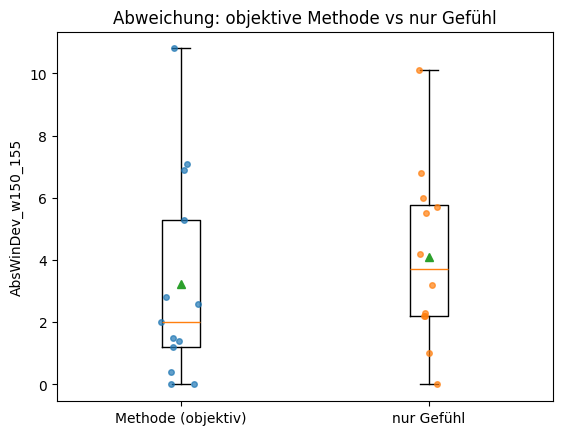

In [23]:
################
# HYPOTHESE 14 #
################

def p_one_sided(p_two, stat, direction="negative"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

# Definitionen nach deiner Aussage:
COL_FEEL = "Nutzung Methode_Augenmaß / Gefühl"
OBJ_COLS = [
    "Nutzung Methode_Formeln / Berechnung nach Beinlänge",
    "Nutzung Methode_Fersenmethode",
    "Nutzung Methode_Kniewinkel",
    "Nutzung Methode_Hüfte",
    "Nutzung Methode_Einstellung durch Laden / Mechaniker",
]

need = [YCOL, COL_FEEL] + OBJ_COLS
sub = df[need].dropna().copy()

# Gruppe "Gefühl": Augenmaß/Gefühl == 1 UND keine objektive Methode genutzt
sub["grp_feel_only"] = (sub[COL_FEEL].astype(int) == 1) & (sub[OBJ_COLS].sum(axis=1).astype(int) == 0)

# Gruppe "Methode": mind. eine objektive Methode genutzt (egal ob zusätzlich Gefühl)
sub["grp_method"] = (sub[OBJ_COLS].sum(axis=1).astype(int) > 0)

g_method = sub.loc[sub["grp_method"], YCOL]
g_feel   = sub.loc[sub["grp_feel_only"], YCOL]

print("n Methode (objektiv >=1):", len(g_method), "| n Gefühl-only:", len(g_feel))
print("Means:", {"Methode": g_method.mean() if len(g_method)>0 else np.nan,
                "Gefühl-only": g_feel.mean() if len(g_feel)>0 else np.nan})

if len(g_method) >= 2 and len(g_feel) >= 2:
    t, p2 = stats.ttest_ind(g_method, g_feel, equal_var=False)
    p1 = p_one_sided(p2, t, direction="negative")  # H1: Methode < Gefühl-only

    print(f"Welch t-test: t={t:.4f}, p(zweiseitig)={p2:.6f}")
    print(f"Einseitig (H1: Methode < Gefühl-only): p={p1:.6f}")

    fig, ax = plt.subplots()
    ax.boxplot([g_method.values, g_feel.values],
               tick_labels=["Methode (objektiv)", "nur Gefühl"],
               showmeans=True)
    for i, vals in enumerate([g_method.values, g_feel.values], start=1):
        ax.plot(np.random.normal(i, 0.04, len(vals)), vals, "o", alpha=0.7, markersize=4)
    ax.set_ylabel(YCOL)
    ax.set_title("Abweichung: objektive Methode vs nur Gefühl")
    plt.show()
else:
    print("Test nicht möglich: mindestens eine Gruppe hat zu wenig Daten (n<2).")
    fig, ax = plt.subplots()
    ax.bar(["Methode (objektiv)", "nur Gefühl"], [len(g_method), len(g_feel)])
    ax.set_ylabel("n")
    ax.set_title("Gruppengrößen für Hypothese 14")
    plt.show()


Spearman: rho=0.0068, p(zweiseitig)=0.974122, n=25
Einseitig (H1: rho > 0): p=0.487061


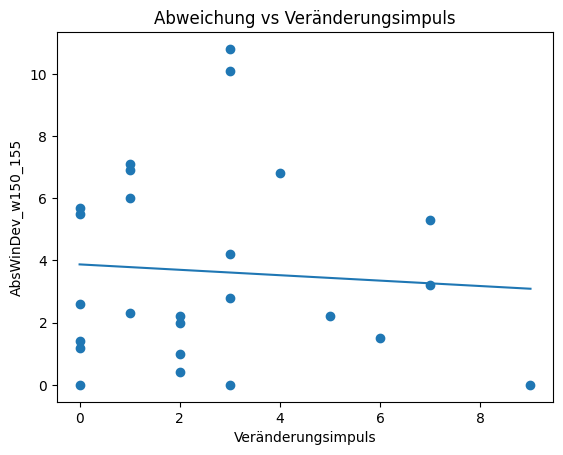

In [24]:
################
# HYPOTHESE 15 #
################

def p_one_sided(p_two, stat, direction="positive"):
    return (p_two/2) if ((direction=="negative" and stat < 0) or (direction=="positive" and stat > 0)) else (1 - p_two/2)

sub = df[[YCOL, "Veränderungsimpuls"]].dropna()
rho, p2 = stats.spearmanr(sub["Veränderungsimpuls"], sub[YCOL])
p1 = p_one_sided(p2, rho, direction="positive")

print(f"Spearman: rho={rho:.4f}, p(zweiseitig)={p2:.6f}, n={len(sub)}")
print(f"Einseitig (H1: rho > 0): p={p1:.6f}")

fig, ax = plt.subplots()
ax.scatter(sub["Veränderungsimpuls"], sub[YCOL])
m, b = np.polyfit(sub["Veränderungsimpuls"], sub[YCOL], 1)
xs = np.linspace(sub["Veränderungsimpuls"].min(), sub["Veränderungsimpuls"].max(), 100)
ax.plot(xs, m*xs + b)
ax.set_xlabel("Veränderungsimpuls")
ax.set_ylabel(YCOL)
ax.set_title("Abweichung vs Veränderungsimpuls")
plt.show()


## Interpretation der H1-Hypothesen (Outcome: **Abweichung vom optimalen Kniewinkel** – *kleiner = besser*)

> **Hinweis zur Lesart:** Ein **nicht signifikanter p-Wert** (z. B. p > 0,05) bedeutet, dass mit diesen Daten **kein belastbarer statistischer Hinweis** auf den postulierten Zusammenhang/Unterschied gefunden wurde. Richtungsangaben (positiv/negativ) beschreiben nur die beobachtete Tendenz in der Stichprobe.

---

### H1: Unterschied zwischen „weiblich“ und „männlich“
- **Test:** Welch-t-Test (zweiseitig)  
- **Ergebnis:** *t* = −0,383; **p = 0,708**; Mittelwerte: weiblich **3,30** (n=6) vs. männlich **3,76** (n=19)  
- **Interpretation:** **Kein signifikanter Geschlechtsunterschied** in der Abweichung. Die beobachtete Differenz ist klein und kann gut zufallsbedingt sein.

---

### H2: Zusammenhang Alter ↔ Abweichung
- **Test:** lineare Regression (zweiseitig)  
- **Ergebnis:** Steigung **+0,252**; r = 0,188; **p = 0,368** (n=25)  
- **Interpretation:** **Kein statistisch gesicherter Zusammenhang**. In den Daten zeigt sich höchstens eine schwache Tendenz, dass die Abweichung mit dem Alter **eher zunimmt**, aber nicht belastbar.

---

### H3: Zusammenhang Körpergröße ↔ Abweichung
- **Test:** lineare Regression (zweiseitig)  
- **Ergebnis:** Steigung **+0,080**; r = 0,248; **p = 0,231** (n=25)  
- **Interpretation:** **Kein signifikanter Zusammenhang**. Falls überhaupt, deutet die Stichprobe schwach auf **größere Abweichungen bei größerer Körpergröße** hin – jedoch ohne Evidenz.

---

### H4: Zusammenhang Beininnenlänge ↔ Abweichung
- **Test:** lineare Regression (zweiseitig)  
- **Ergebnis:** Steigung **+0,164**; r = 0,263; **p = 0,204** (n=25)  
- **Interpretation:** **Kein signifikanter Zusammenhang**. Die beobachtete Richtung ist eher **positiv** (längere Beine → größere Abweichung), aber statistisch nicht abgesichert.

---

### H5: Benötigte Zeit für Sattelhöheneinstellung ↑ → Abweichung ↓
- **Test:** lineare Regression; **einseitig** (H1: Steigung < 0)  
- **Ergebnis:** Steigung **+0,0047**; p(zweiseitig)=0,574; **p(einseitig)=0,713** (n=25)  
- **Interpretation:** **Keine Unterstützung** für die Hypothese; in der Stichprobe ist die Steigung sogar minimal **positiv** (mehr Zeit → eher etwas mehr Abweichung), aber praktisch/ statistisch unklar.

---

### H6: km/Woche ↑ → Abweichung ↓
- **Test:** lineare Regression; **einseitig** (H1: Steigung < 0)  
- **Ergebnis:** Steigung **+0,024**; p(zweiseitig)=0,394; **p(einseitig)=0,803** (n=25)  
- **Interpretation:** **Keine Evidenz** für „mehr Kilometer = näher am Optimum“. Die beobachtete Tendenz ist eher entgegengesetzt (leicht positiv), aber nicht belastbar.

---

### H7: Nutzungsfrequenz pro Woche ↑ → Abweichung ↓
- **Test:** lineare Regression; **einseitig** (H1: Steigung < 0)  
- **Ergebnis:** Steigung **+0,118**; p(zweiseitig)=0,762; **p(einseitig)=0,619** (n=25)  
- **Interpretation:** **Kein Zusammenhang** erkennbar; die Daten stützen die Hypothese nicht.

---

### H8: Dauer „aktiv Fahrrad fahren“ ↑ → Abweichung ↓
- **Test:** lineare Regression; **einseitig** (H1: Steigung < 0)  
- **Ergebnis:** Steigung **+0,170**; r = 0,393; p(zweiseitig)=0,052; **p(einseitig)=0,974** (n=25)  
- **Interpretation:** Die erwartete **negative** Richtung wird **nicht** unterstützt. Stattdessen zeigt sich eine **nahezu signifikante** Tendenz in die **Gegenrichtung** (länger aktiv → eher **größere** Abweichung), aber bei p≈0,052 zweiseitig bleibt es **nicht signifikant** auf 5%-Niveau.

---

### H9: Nutzung als Sportgerät → geringere Abweichung (als „nicht Sport“)
- **Test:** Welch-t-Test; **einseitig** (H1: Sport < nicht)  
- **Ergebnis:** *t* = +1,387; p(zweiseitig)=0,180; **p(einseitig)=0,910**; Mittelwerte: Sport **4,59** (n=11) vs. nicht **2,91** (n=14)  
- **Interpretation:** **Keine Unterstützung**, im Gegenteil: In dieser Stichprobe haben „Sport/Training“-Nutzende **im Mittel größere Abweichungen**. Statistisch ist das aber **nicht signifikant**.

---

### H10: Nutzung als Fortbewegungsmittel → geringere Abweichung (als „nicht Fortbewegung“)
- **Test:** Welch-t-Test; **einseitig** (H1: Fortbewegung < nicht)  
- **Ergebnis:** *t* = +1,697; p(zweiseitig)=0,105; **p(einseitig)=0,947**  
- **Interpretation:** **Keine Evidenz** für die Hypothese; die Richtung ist erneut eher **entgegengesetzt** (Fortbewegung-Gruppe tendenziell **höhere** Abweichung), aber nicht signifikant.

---

### H11: Unterschied zwischen Fahrradtypen (Rennrad/Gravel/Mountain/City/Sonstige)
- **Test:** Kruskal-Wallis (zweiseitig) + zusätzlich Mixed-Model-Ansatz für Mehrfachnennungen  
- **Ergebnis (KW):** H = 1,893; **p = 0,755**; Gruppen-n: Citybike 8, Mehrfach 7, Mountainbike 6, Rennrad 2, Sonstige 1  
- **Ergebnis (Mixed-Model Omnibus):** LR = 0,096; **p = 0,999**  
- **Interpretation:** **Keine Hinweise** darauf, dass sich die Abweichung **zwischen Fahrradtypen** unterscheidet (auch nicht, wenn Mehrfachnennungen modelliert werden).

---

### H12: Bessere Selbsteinschätzung (Zuverlässigkeit) ↑ → Abweichung ↓
- **Test:** Spearman-Korrelation; **einseitig** (H1: rho < 0)  
- **Ergebnis:** rho = **+0,213**; p(zweiseitig)=0,306; **p(einseitig)=0,847** (n=25)  
- **Interpretation:** **Keine Unterstützung**; die beobachtete Richtung ist sogar leicht **positiv** (bessere Selbsteinschätzung → eher größere Abweichung), aber ohne statistische Evidenz.

---

### H13: Je kürzer seit letztem professionellen Bike Fitting → geringere Abweichung
- **Test:** Spearman-Korrelation; **einseitig** (H1: rho > 0, d. h. „länger her“ → mehr Abweichung)  
- **Ergebnis:** rho = **+0,062**; p(zweiseitig)=0,767; **p(einseitig)=0,383** (n=25)  
- **Interpretation:** **Kein nachweisbarer Zusammenhang** zwischen „Zeit seit Bikefitting“ und Abweichung in dieser Stichprobe.

---

### H14: Mindestens eine Methode genutzt → geringere Abweichung als „nur Gefühl“
- **Test:** Welch-t-Test; **einseitig** (H1: Methode < Gefühl-only)  
- **Ergebnis:** Mittelwerte: Methode **3,23** (n=13) vs. Gefühl-only **4,10** (n=12); *t* = −0,706; p(zweiseitig)=0,488; **p(einseitig)=0,244**  
- **Interpretation:** **Tendenz in erwarteter Richtung** (Methoden-Gruppe im Mittel besser), aber **nicht signifikant** → aus den Daten folgt **kein belastbarer** Effekt.

---

### H15: Geringerer Veränderungsimpuls (während finaler Messung) → geringere Abweichung
- **Test:** Spearman-Korrelation; **einseitig** (H1: rho > 0, d. h. mehr Impuls → mehr Abweichung)  
- **Ergebnis:** rho = **+0,007**; p(zweiseitig)=0,974; **p(einseitig)=0,487** (n=25)  
- **Interpretation:** **Kein Zusammenhang**; der Veränderungsimpuls hängt in diesen Daten praktisch **gar nicht** mit der Abweichung zusammen.

---

## Gesamtfazit
Über alle getesteten H1-Hypothesen hinweg ergab sich **keine statistisch signifikante Unterstützung** (α = 0,05). Einzelne Effekte zeigen zwar Richtungen/Tendenzen, diese sind jedoch **unsicher** (kleine Stichprobe, teils ungleiche Gruppen, teils Gegenrichtung zur Erwartung).
